# Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage.io import imread, imsave
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
import keras
import keras.layers

sys.path.insert(0, '../')
from src.utils import *
from src.config import *
from src.prepare_data import prepare_SPARCS, prepare_biome8, prepare_S2
from skimage.util import view_as_windows

seed_value = 42

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Set the random seed for numpy
np.random.seed(seed_value)

# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)

2023-08-07 07:52:46.772926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 07:52:47.815131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Setup

Prepare the original 1000x1000 images for the CNN, patching them into 256x256 images with 64 pixels of overlap.

In [2]:
prepare_SPARCS(patch_size=256, overlap=64)

test: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [3]:
get_SPARCS()[0].shape, get_SPARCS()[1].shape, get_SPARCS('valid')[0].shape, get_SPARCS('valid')[1].shape, get_SPARCS('test')[0].shape, get_SPARCS('test')[1].shape

((992, 256, 256, 4),
 (992, 256, 256, 1),
 (128, 256, 256, 4),
 (128, 256, 256, 1),
 (128, 256, 256, 4),
 (128, 256, 256, 1))

In [4]:
np.unique(get_SPARCS()[1]), np.unique(get_SPARCS('valid')[1]), np.unique(get_SPARCS('test')[1])

(array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8))

In [5]:
get_SPARCS('test', full_image=True, only_rgb=True, binary=False)[0].shape, get_SPARCS('test', full_image=True, only_rgb=True, binary=False)[1].shape

((8, 1000, 1000, 3), (8, 1000, 1000, 7))

In [6]:
get_SPARCS('valid', full_image=True, only_rgb=True, binary=False)[0].shape, get_SPARCS('valid', full_image=True, only_rgb=True, binary=False)[1].shape

((8, 1000, 1000, 3), (8, 1000, 1000, 7))

In [7]:
# Load product names
products = sorted(os.listdir(sparcs_raw_dir))
prods = [(f.split('_')[0]+'_'+f.split('_')[1]) for f in products if '_' in f]

labels = [f for f in products if '_labels.tif' in f]
bands = [f for f in products if '_data.tif' in f]
photos = [f for f in products if '_photo.png' in f]
qmasks = [f for f in products if '_qmask.tif' in f]
c1qba = [f for f in products if '_c1bqa.tif' in f]

# prods = [p for p in prods if any(p in label for label in labels) and
#          any(p in d for d in bands) and any(p in photo for photo in photos) and
#          any(p in qmask for qmask in qmasks) and any(p in cqba for cqba in c1qba)]

prods = [p for p in prods if any(p in label for label in labels) and any(p in d for d in bands)]
prods = np.unique(prods)


print(f'The folder contains {len(prods)} images.')


The folder contains 78 images.


In [8]:
# Select the image we want to analyze
p = prods[1]

# Labels

array([0, 1, 2, 4, 5], dtype=uint8)

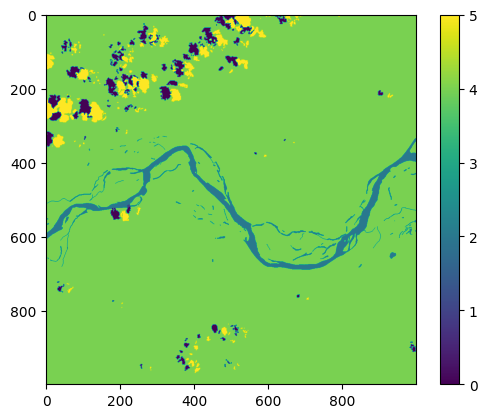

In [9]:
# labels = tiff.imread(Path(raw_path, "LC82320772014306LGN00_38_labels.tif"))
label = tiff.imread(Path(sparcs_raw_dir, [l for l in labels if p in l][0]))

plt.imshow(label)
plt.colorbar()
np.unique(label)

# There are the available classes
#  Mask Code	Feature	                Mapped Color
#     0	    Cloud Shadow                Black
#     1	    Cloud Shadow over Water     Dark Blue
#     2	    Water                       Blue
#     3	    Ice/Snow                    Cyan
#     4	    Land                        Grey
#     5	    Clouds                      White
#     6	    Flooded                     Gold

# Bands

The bands can be seen here: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites

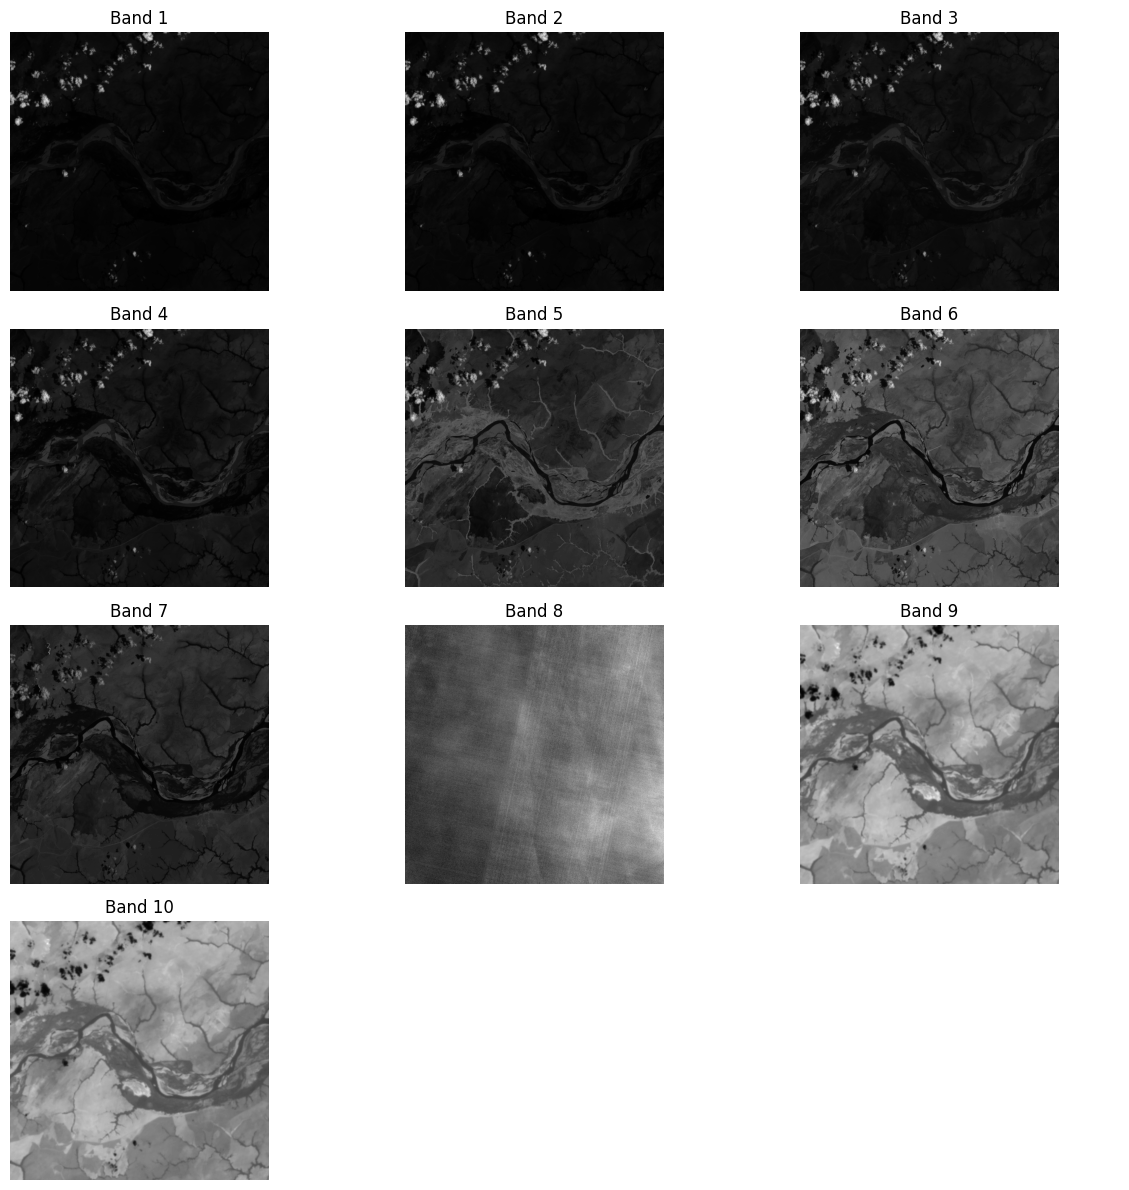

In [10]:
data = tiff.imread(Path(sparcs_raw_dir, [l for l in bands if p in l][0]))

# 16-bit unsigned integer (uint16)
data = data.astype(float) / 65535.0

# The bands can be seen here: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites

# Determine the shape of the data
num_bands = data.shape[2]

# Calculate the number of rows and columns for the subplots
num_rows = int(np.ceil(np.sqrt(num_bands)))
num_cols = int(np.ceil(num_bands / num_rows))

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Iterate over the bands and plot each slice
for i in range(num_bands):
    axs[i].imshow(data[:, :, i], cmap='gray')
    axs[i].set_title("Band {}".format(i + 1))
    axs[i].axis('off')

# Hide any remaining empty subplots
for j in range(num_bands, len(axs)):
    axs[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

## We are mainly interested in the following bands:
- RGB: 4, 3, 2
- NIR (Near Infrared): 5

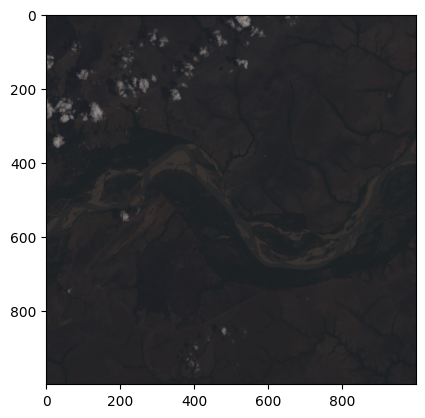

In [11]:
# RGB image
data = tiff.imread(Path(sparcs_raw_dir, [l for l in bands if p in l][0]))
im = (data[:,:,1:4]/65535.0)*255.0
im = im.astype(np.uint8)
im = rgb_image_from_bands_array(im)
plt.imshow(im)

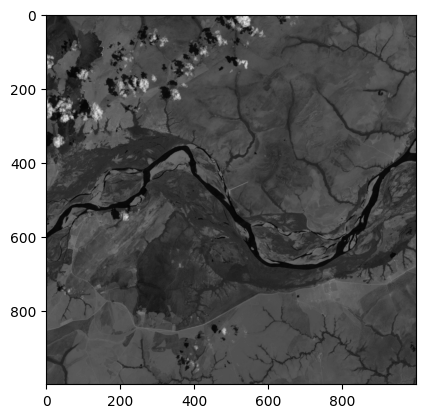

In [12]:
# NIR image
im = (data[:,:,5]/65535.0)*255.0
im = im.astype(np.uint8)
plt.imshow(im, cmap='gray')

## How the patches are extracted

(4, 4, 256, 256, 3)


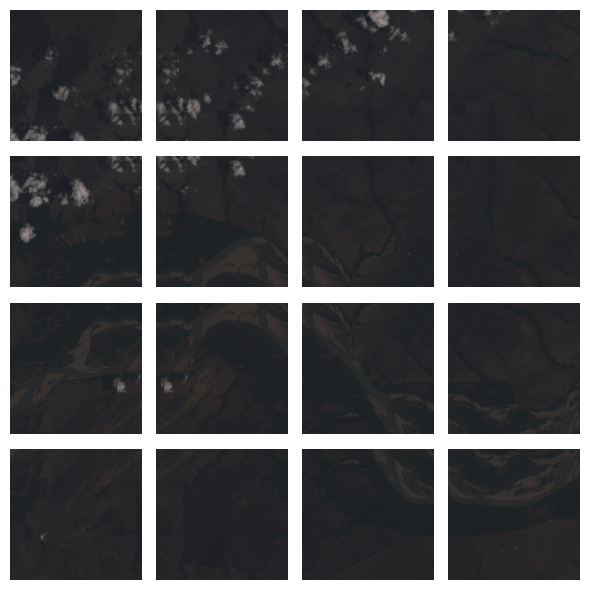

In [13]:
# Load image
im = (data[:,:,1:4]/65535.0)*255.0
im = im.astype(np.uint8)
im = rgb_image_from_bands_array(im)

patch_size = (256, 256, 3)
stride = 256-64


def extract_patches(image, patch_size, stride):
    patches = view_as_windows(image, patch_size, step=stride)
    patches = np.squeeze(patches)
    return patches

ims_patches = extract_patches(im, patch_size, stride)

print(ims_patches.shape)

# ims_patches = patches[:26]
# Create the subplots
# fig, axs = plt.subplots(5, 5, figsize=(6, 6))
# fig, axs = plt.subplots(6, 6, figsize=(6, 6))
fig, axs = plt.subplots(4, 4, figsize=(6, 6))



# Iterate over the bands and plot each slice
for x in range(ims_patches.shape[0]):
    for y in range(ims_patches.shape[1]):
        axs[x][y].imshow(ims_patches[x, y, :], vmin=0, vmax=255)
        axs[x][y].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# Interpreter photo

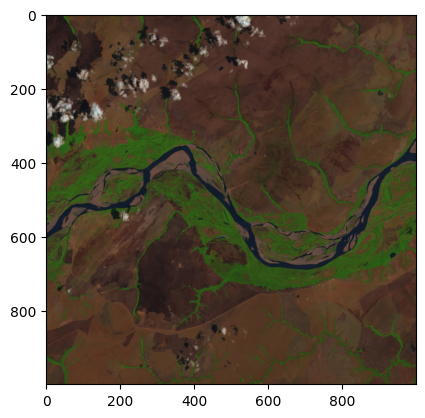

In [14]:
# Photo used by the annotator

photo = skimage.io.imread(Path(sparcs_raw_dir, [ph for ph in photos if p in ph][0]))

plt.imshow(photo)

# USGS quality mask

array([20480, 20512, 36864, 53248], dtype=uint16)

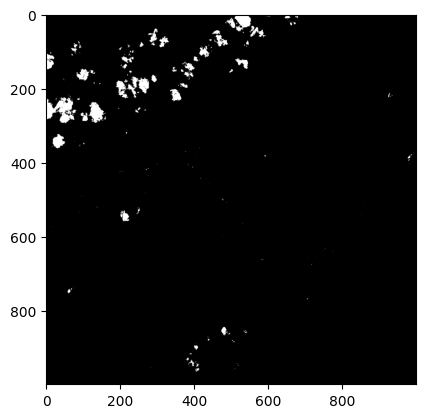

In [15]:
mask = tiff.imread(Path(sparcs_raw_dir, [q for q in qmasks if p in q][0]))
# mask = mask.astype(float) / 65535.0
plt.imshow(mask, cmap='gray')
np.unique(mask)

array([2720, 2724, 2752, 2800, 2976, 2980, 3008], dtype=uint16)

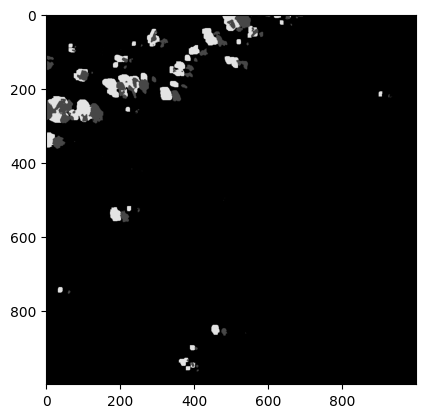

In [16]:
cmask = tiff.imread(Path(sparcs_raw_dir, [q for q in c1qba if p in q][0]))
# cmask = cmask.astype(float) / 65535.0
plt.imshow(cmask, cmap='gray')
np.unique(cmask)

# Distribution

In [17]:
# Have at least one pixel for each class to avoid issues with the colors in the figure
sparcs_classes = np.zeros((7))
sparcs_classes[0] = 0  # see classes at: https://landsat.usgs.gov/sparcs
sparcs_classes[1] = 1
sparcs_classes[2] = 2
sparcs_classes[3] = 3
sparcs_classes[4] = 4
sparcs_classes[5] = 5
sparcs_classes[6] = 6


sparcs_pixels_per_class = np.zeros((np.size(prods), 7))  # 78 products with 5 classes
sparcs_band_mean_per_product = np.zeros((np.size(prods), 10))  # 78 products with 11 bands
sparcs_band_std_per_product = np.zeros((np.size(prods), 10))  # 78 products with 11 bands
sparcs_band_max_per_product = np.zeros((np.size(prods), 10))  # 78 products with 11 bands
mask = np.zeros((1000, 1000, 1))
img_all_bands = np.zeros((1000, 1000, 10))

print('Processing started')
for i, product in enumerate(prods):
    # mask[:, :, 0] = Image.open(raw_path + product[:-8] + "mask.png")
    mask[:, :, 0] = tiff.imread(Path(sparcs_raw_dir, f"{product}_labels.tif"))
    # mask[:, :, 0] = Image.open(raw_path + product[:-8] + "mask.png")
    for j, c in enumerate(sparcs_classes):
        sparcs_pixels_per_class[i, j] = np.count_nonzero(mask == c)

    # img_all_bands[:, :, 0:8] = tiff.imread(toa_path + product[:-8] + "toa.TIF")
    # img_all_bands[:, :, 8:10] = tiff.imread(raw_path + product)[:, :, 8:10]
    img_all_bands[:, :, :] = tiff.imread(Path(sparcs_raw_dir, f"{product}_data.tif"))
    
    for j in range(0, 10): 
        sparcs_band_mean_per_product[i, j] = np.mean(img_all_bands[:, :, j])
        sparcs_band_std_per_product[i, j] = np.std(img_all_bands[:, :, j])  
        sparcs_band_max_per_product[i, j] = np.percentile(img_all_bands[:, :, j], 0.98)  # Discard uppermost 2 percent to ignore outliers
        
print('Processing done')

Processing started
Processing done


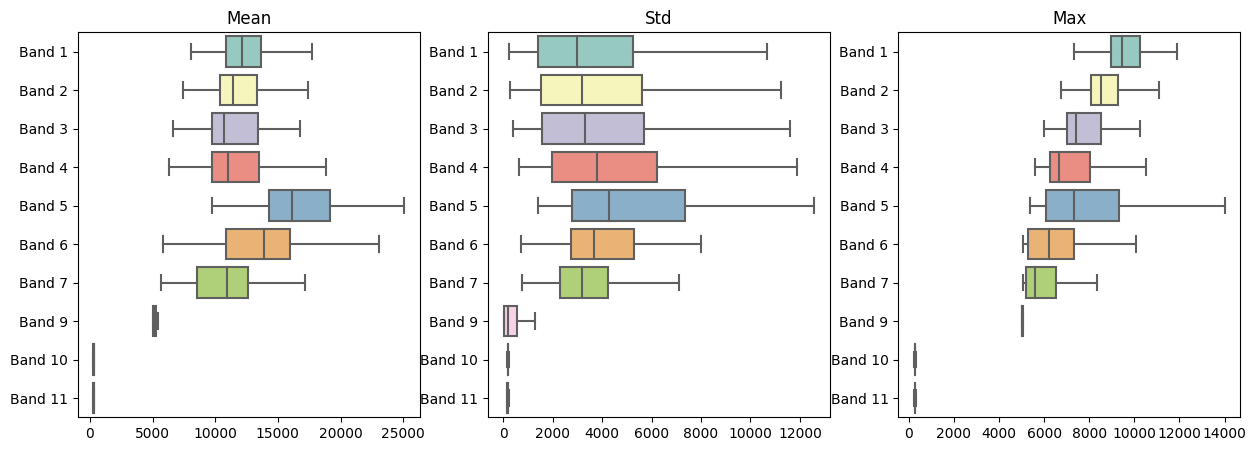

In [18]:
# Scaling for TIRS instrument (band 10 and 11) is from https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
RADIANCE_MULT_BAND_10 = 3.3420E-04  # Parameters from any of the Landsat 8 mtl files
RADIANCE_MULT_BAND_11 = 3.3420E-04
RADIANCE_ADD_BAND_10 = 0.10000
RADIANCE_ADD_BAND_11 = 0.10000
K1_CONSTANT_BAND_10 = 774.89  
K1_CONSTANT_BAND_11 = 480.89
K2_CONSTANT_BAND_10 = 1321.08
K2_CONSTANT_BAND_11 = 1201.14

df_sparcs_mean = pd.DataFrame({'Band 1':sparcs_band_mean_per_product[:,0],
                               'Band 2':sparcs_band_mean_per_product[:,1],
                               'Band 3':sparcs_band_mean_per_product[:,2],
                               'Band 4':sparcs_band_mean_per_product[:,3],
                               'Band 5':sparcs_band_mean_per_product[:,4],
                               'Band 6':sparcs_band_mean_per_product[:,5],
                               'Band 7':sparcs_band_mean_per_product[:,6],
                               'Band 9':sparcs_band_mean_per_product[:,7],
                               'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_mean_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                               'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_mean_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_sparcs_std = pd.DataFrame({'Band 1':sparcs_band_std_per_product[:,0],
                              'Band 2':sparcs_band_std_per_product[:,1],
                              'Band 3':sparcs_band_std_per_product[:,2],
                              'Band 4':sparcs_band_std_per_product[:,3],
                              'Band 5':sparcs_band_std_per_product[:,4],
                              'Band 6':sparcs_band_std_per_product[:,5],
                              'Band 7':sparcs_band_std_per_product[:,6],
                              'Band 9':sparcs_band_std_per_product[:,7],
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_std_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_std_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_sparcs_max = pd.DataFrame({'Band 1':sparcs_band_max_per_product[:,0],
                              'Band 2':sparcs_band_max_per_product[:,1],
                              'Band 3':sparcs_band_max_per_product[:,2],
                              'Band 4':sparcs_band_max_per_product[:,3],
                              'Band 5':sparcs_band_max_per_product[:,4],
                              'Band 6':sparcs_band_max_per_product[:,5],
                              'Band 7':sparcs_band_max_per_product[:,6],
                              'Band 9':sparcs_band_max_per_product[:,7],
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_max_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_max_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

# Plot 
plt.figure(figsize=(15, 5))
order = ["Band 1", "Band 2", "Band 3", "Band 4", "Band 5", "Band 6", "Band 7", 
         "Band 9", "Band 10", "Band 11"]

plt.subplot(1, 3, 1)
plt.title('Mean')
sns.boxplot(data=df_sparcs_mean, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 2)
plt.title('Std')
sns.boxplot(data=df_sparcs_std, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 3)
plt.title('Max')
sns.boxplot(data=df_sparcs_max, order=order, palette="Set3",  orient="h", showfliers=False)

plt.show()

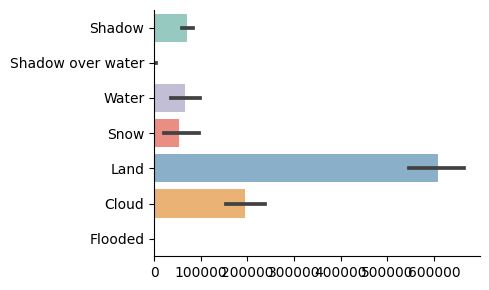

In [19]:
df_sparcs_mask = pd.DataFrame({'Shadow':sparcs_pixels_per_class[:,0],
                               'Shadow over water':sparcs_pixels_per_class[:,1],
                               'Water':sparcs_pixels_per_class[:,2],
                               'Snow':sparcs_pixels_per_class[:,3],
                               'Land':sparcs_pixels_per_class[:,4],
                               'Cloud':sparcs_pixels_per_class[:,5],
                               'Flooded':sparcs_pixels_per_class[:,6]})

# Draw a count plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_sparcs_mask, palette="Set3",  orient="h")
sns.despine()
plt.tight_layout()
plt.show()

# Sources:
* Data exploration: https://github.com/JacobJeppesen/RS-Net/blob/master/notebooks/jhj_ArticleFigures_DatasetDistributions.ipynb